In [1]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import pandas as pd
import os
import pydicom
import numpy as np
import h5py
import time
from tqdm import tqdm as tqdm
import cv2
import pickle
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
import random
from torch import nn
from torch.autograd import Variable

Image Level
===========

In [44]:
class StudyLevelDataset(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        
        self.hdf5_filename = '/scratch/features.hdf5'
        
        self._generate_row_indices_list()
        
        self.stage = stage
        
        if self.stage == 'train':
            self.start = 0
            self.end = 2650
        else:
            self.start = 2660
            self.end = 3500
        
        # 0 - 2650 train
        # 2660 - 3500 valid

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        return self.end - self.start + 1
        #return num_pos_samples_per_dataset + num_neg_samples_per_dataset
        
    def _generate_row_indices_list(self):
        # group slice indices into studies
        self.row_indices = [] # index into train df for every study
        current_study_id = ''

        for slice_index in range(len(self.pedataframe)):
            new_study_id = self.pedataframe.StudyInstanceUID[slice_index]
            if new_study_id != current_study_id:
                self.row_indices.append(slice_index)
                current_study_id = new_study_id
            if slice_index % 100000 == 0:
                print(slice_index)
        
    def __getitem__(self, study_index):
        '''  '''
        study_index = study_index + self.start
        
        h5py_file = h5py.File(self.hdf5_filename, "r")
        
        start_index = self.row_indices[study_index]
        if study_index+1 < len(self.row_indices):
            stop_index = self.row_indices[study_index+1]
        else:
            stop_index = len(self.pedataframe)
            
        # dim: seq_len x embedding_dim
        x = np.ones((stop_index-start_index, 1280))  #embedding dim = 1280 for efficientnetb0
        y = np.ones(stop_index-start_index)
            
        for slice_index in range(start_index, stop_index):
            data_identifier = 'tensor(' + str(slice_index) + ')'
            slice_embeddings = h5py_file[data_identifier][:]
            x[slice_index-start_index,:] = slice_embeddings
            
            pe_present_on_image = float(int(self.pedataframe.pe_present_on_image[slice_index]))
            y[slice_index-start_index] = pe_present_on_image
        
        h5py_file.close()
        
        return x, y

In [45]:
hdf5_filename = '/scratch/features.hdf5'
h5py_file = h5py.File(hdf5_filename, "r")
h5py_file['tensor(12)'][:]

h5py_file.close()

In [46]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train_dataset = StudyLevelDataset(csv_file=train_csv, stage='train')
valid_dataset = StudyLevelDataset(csv_file=train_csv, stage='valid')

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [47]:
'''
https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
'''

batch_size = 1
embedding_dim = 1280
nb_lstm_units = 64

class MyLSTM(nn.Module):
    def __init__(self, nb_layers=1, nb_lstm_units=nb_lstm_units, 
                 embedding_dim=embedding_dim, batch_size=batch_size):
        
        super(MyLSTM, self).__init__()

        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True
        )

        # output layer
        self.linear = nn.Linear(self.nb_lstm_units, 1)

    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_h0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)
        hidden_c0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)

        hidden_h0 = hidden_h0.to(device)
        hidden_c0 = hidden_c0.to(device)

        hidden_h0 = Variable(hidden_h0)
        hidden_c0 = Variable(hidden_c0)

        return (hidden_h0.to(device), hidden_c0.to(device))
    
    def forward(self, X):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        batch_size, seq_len, _ = X.size()

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        #X = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)

        # undo the packing operation
        #X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        # this one is a bit tricky as well. First we need to reshape the data so it goes into the linear layer
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.linear(X)

        # ---------------------
        # 4. Create softmax activations bc we're doing classification
        # Dim transformation: (batch_size * seq_len, nb_lstm_units) -> (batch_size, seq_len, nb_tags)
        #X = torch.sigmoid(X)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, seq_len)

        Y_hat = X
        return Y_hat

In [48]:
model = MyLSTM()
model

MyLSTM(
  (lstm): LSTM(1280, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [49]:
device = 'cpu'
model.to(device)
x,y = train_dataset[1]
x = torch.tensor(x)
x = x.unsqueeze(0).float()
x = x.to(device)

pred = model(x)

In [30]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

dummy = None

def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))

    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []
    pos_logits = []
    neg_logits = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data.float())

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(float(loss_np))

            logits = logits.squeeze()
            target = target.squeeze()
            
            for i in range(logits.shape[-1]):
                b = target[i].detach().cpu().numpy()
                if b == 1:
                    pos_logits.append(float(logits[i].detach().cpu().numpy()))
                else:
                    neg_logits.append(float(logits[i].detach().cpu().numpy()))
                    
    val_loss_mean = sum(val_loss) / len(val_loss)
    
    neg_logits_tensor = torch.FloatTensor(neg_logits).cuda()
    pos_logits_tensor = torch.FloatTensor(pos_logits).cuda()
    
    neg_loss = criterion(neg_logits_tensor, torch.zeros(neg_logits_tensor.shape).float().cuda())
    pos_loss = criterion(pos_logits_tensor, torch.ones(pos_logits_tensor.shape).float().cuda())
    
    neg_loss = neg_loss.detach().cpu().numpy()
    pos_loss = pos_loss.detach().cpu().numpy()
    
    neg_mean = float(torch.sigmoid(neg_logits_tensor).mean().detach().cpu().numpy())
    pos_mean = float(torch.sigmoid(pos_logits_tensor).mean().detach().cpu().numpy())
    
    return float(val_loss_mean), float(pos_loss), float(neg_loss), pos_mean, neg_mean

def get_optimizer(lr, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    return optimizer

init_lr = 0.1
n_epochs = 20
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
#gamma = 10
#schedule = [10, 20, 30]

#model = resnext101.to(device)
optimizer = get_optimizer(init_lr, model)
model.to(device)

master_train_loss = []
master_valid_loss = []
epoch = 1
#best_valid_loss = 10


while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    #if epoch in schedule:
    #    new_lr = optimizer.param_groups[0]["lr"] / gamma
     #   optimizer = get_optimizer(new_lr, model)
    
    #train_loader, valid_loader = get_loaders(epoch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,num_workers=1)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,num_workers=1)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss, pos_loss, neg_loss, pos_mean, neg_mean = valid_epoch(model, valid_loader)
    #valid_loss = 0
    #pos_loss  = 0
    #neg_loss = 0
    #pos_mean = 0
    #neg_mean = 0
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    content = f'pos loss: {(pos_loss):.5f}, neg loss: {(neg_loss):.5f}, pos mean: {(pos_mean):.5f}, neg mean {(neg_mean):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    #with open('train_loss.pkl', 'wb') as f:
        #pickle.dump(master_train_loss, f)
    #with open('valid_loss.pkl', 'wb') as f:
        #pickle.dump(master_valid_loss, f)
        
        #torch.save(model.state_dict(), 'model-resnext-50-{}.pth'.format(epoch))
        #best_valid_loss = valid_loss
    
    epoch += 1
           

  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:04:33 2020 Epoch: 1


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:09:57 2020 Epoch 1, lr: 0.1000000, train loss: 0.12839, valid loss: 0.12487
pos loss: 1.17129, neg loss: 0.06634, pos mean: 0.45012, neg mean 0.05509
Tue Dec  8 11:09:57 2020 Epoch: 2


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:15:17 2020 Epoch 2, lr: 0.1000000, train loss: 0.12375, valid loss: 0.12043
pos loss: 1.13419, neg loss: 0.06367, pos mean: 0.46676, neg mean 0.05254
Tue Dec  8 11:15:17 2020 Epoch: 3


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:20:37 2020 Epoch 3, lr: 0.1000000, train loss: 0.12157, valid loss: 0.11103
pos loss: 1.23130, neg loss: 0.04848, pos mean: 0.44312, neg mean 0.04011
Tue Dec  8 11:20:37 2020 Epoch: 4


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:25:57 2020 Epoch 4, lr: 0.1000000, train loss: 0.11882, valid loss: 0.10838
pos loss: 1.23142, neg loss: 0.04574, pos mean: 0.45890, neg mean 0.03731
Tue Dec  8 11:25:57 2020 Epoch: 5


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:31:18 2020 Epoch 5, lr: 0.1000000, train loss: 0.11813, valid loss: 0.10818
pos loss: 1.17500, neg loss: 0.04841, pos mean: 0.48427, neg mean 0.03874
Tue Dec  8 11:31:18 2020 Epoch: 6


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:36:38 2020 Epoch 6, lr: 0.1000000, train loss: 0.11799, valid loss: 0.10800
pos loss: 1.17124, neg loss: 0.04854, pos mean: 0.48483, neg mean 0.03887
Tue Dec  8 11:36:38 2020 Epoch: 7


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:41:57 2020 Epoch 7, lr: 0.1000000, train loss: 0.11733, valid loss: 0.10741
pos loss: 1.20368, neg loss: 0.04607, pos mean: 0.48312, neg mean 0.03684
Tue Dec  8 11:41:57 2020 Epoch: 8


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:47:22 2020 Epoch 8, lr: 0.1000000, train loss: 0.11703, valid loss: 0.10863
pos loss: 1.14463, neg loss: 0.05072, pos mean: 0.50119, neg mean 0.03988
Tue Dec  8 11:47:22 2020 Epoch: 9


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:52:37 2020 Epoch 9, lr: 0.1000000, train loss: 0.11644, valid loss: 0.10624
pos loss: 1.15733, neg loss: 0.04738, pos mean: 0.49632, neg mean 0.03761
Tue Dec  8 11:52:37 2020 Epoch: 10


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 11:57:44 2020 Epoch 10, lr: 0.1000000, train loss: 0.11652, valid loss: 0.10738
pos loss: 1.18630, neg loss: 0.04699, pos mean: 0.48915, neg mean 0.03742
Tue Dec  8 11:57:44 2020 Epoch: 11


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:02:48 2020 Epoch 11, lr: 0.1000000, train loss: 0.11666, valid loss: 0.10761
pos loss: 1.13905, neg loss: 0.04980, pos mean: 0.49909, neg mean 0.03957
Tue Dec  8 12:02:48 2020 Epoch: 12


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:08:06 2020 Epoch 12, lr: 0.1000000, train loss: 0.11656, valid loss: 0.10702
pos loss: 1.12150, neg loss: 0.05022, pos mean: 0.50476, neg mean 0.03983
Tue Dec  8 12:08:06 2020 Epoch: 13


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:13:15 2020 Epoch 13, lr: 0.1000000, train loss: 0.11619, valid loss: 0.10627
pos loss: 1.21742, neg loss: 0.04414, pos mean: 0.48315, neg mean 0.03524
Tue Dec  8 12:13:15 2020 Epoch: 14


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:18:22 2020 Epoch 14, lr: 0.1000000, train loss: 0.11636, valid loss: 0.10580
pos loss: 1.19390, neg loss: 0.04494, pos mean: 0.47953, neg mean 0.03641
Tue Dec  8 12:18:22 2020 Epoch: 15


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:23:29 2020 Epoch 15, lr: 0.1000000, train loss: 0.11623, valid loss: 0.10672
pos loss: 1.14549, neg loss: 0.04849, pos mean: 0.50019, neg mean 0.03846
Tue Dec  8 12:23:29 2020 Epoch: 16


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:28:35 2020 Epoch 16, lr: 0.1000000, train loss: 0.11629, valid loss: 0.10621
pos loss: 1.19819, neg loss: 0.04518, pos mean: 0.49082, neg mean 0.03578
Tue Dec  8 12:28:35 2020 Epoch: 17


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:33:55 2020 Epoch 17, lr: 0.1000000, train loss: 0.11614, valid loss: 0.10637
pos loss: 1.16981, neg loss: 0.04693, pos mean: 0.49509, neg mean 0.03723
Tue Dec  8 12:33:55 2020 Epoch: 18


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:39:06 2020 Epoch 18, lr: 0.1000000, train loss: 0.11644, valid loss: 0.10698
pos loss: 1.13271, neg loss: 0.04956, pos mean: 0.50517, neg mean 0.03911
Tue Dec  8 12:39:06 2020 Epoch: 19


  0%|          | 0/841 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2ac3bf0e5cb0>
Traceback (most recent call last):
  File "/share/pkg.7/pytorch/1.5.1/install/3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/share/pkg.7/pytorch/1.5.1/install/3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/share/pkg.7/python3/3.7.7/install/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 12:44:17 2020 Epoch 19, lr: 0.1000000, train loss: 0.11611, valid loss: 0.10584
pos loss: 1.17782, neg loss: 0.04578, pos mean: 0.49396, neg mean 0.03631
Tue Dec  8 12:44:17 2020 Epoch: 20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2ac3bf0e5cb0>
Traceback (most recent call last):
  File "/share/pkg.7/pytorch/1.5.1/install/3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/share/pkg.7/pytorch/1.5.1/install/3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/share/pkg.7/python3/3.7.7/install/lib/python3.7/multiprocessing/process.py", line 138, in join
loss: 0.72533, mean: 0.72533:   0%|          | 1/2651 [00:00<12:30,  3.53it/s]assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
100%|██████████| 841/841 [01:15<00:00, 11.21it/s]


Tue Dec  8 12:49:27 2020 Epoch 20, lr: 0.1000000, train loss: 0.11631, valid loss: 0.10554
pos loss: 1.20415, neg loss: 0.04421, pos mean: 0.48517, neg mean 0.03541


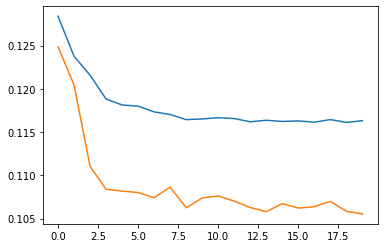

In [35]:
torch.save(model.state_dict(), 'model-efficientb0-lstm1.pth')
plt.plot(master_train_loss[:], label='train')
plt.plot(master_valid_loss[:], label='valid')

In [50]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

dummy = None

def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))

    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []
    pos_logits = []
    neg_logits = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data.float())

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(float(loss_np))

            logits = logits.squeeze()
            target = target.squeeze()
            
            for i in range(logits.shape[-1]):
                b = target[i].detach().cpu().numpy()
                if b == 1:
                    pos_logits.append(float(logits[i].detach().cpu().numpy()))
                else:
                    neg_logits.append(float(logits[i].detach().cpu().numpy()))
                    
    val_loss_mean = sum(val_loss) / len(val_loss)
    
    neg_logits_tensor = torch.FloatTensor(neg_logits).cuda()
    pos_logits_tensor = torch.FloatTensor(pos_logits).cuda()
    
    neg_loss = criterion(neg_logits_tensor, torch.zeros(neg_logits_tensor.shape).float().cuda())
    pos_loss = criterion(pos_logits_tensor, torch.ones(pos_logits_tensor.shape).float().cuda())
    
    neg_loss = neg_loss.detach().cpu().numpy()
    pos_loss = pos_loss.detach().cpu().numpy()
    
    neg_mean = float(torch.sigmoid(neg_logits_tensor).mean().detach().cpu().numpy())
    pos_mean = float(torch.sigmoid(pos_logits_tensor).mean().detach().cpu().numpy())
    
    return float(val_loss_mean), float(pos_loss), float(neg_loss), pos_mean, neg_mean

def get_optimizer(lr, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    return optimizer

init_lr = 0.1
n_epochs = 5
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
#gamma = 10
#schedule = [10, 20, 30]

#model = resnext101.to(device)
optimizer = get_optimizer(init_lr, model)
model.to(device)

master_train_loss = []
master_valid_loss = []
epoch = 1
#best_valid_loss = 10


while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    #if epoch in schedule:
    #    new_lr = optimizer.param_groups[0]["lr"] / gamma
     #   optimizer = get_optimizer(new_lr, model)
    
    #train_loader, valid_loader = get_loaders(epoch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,num_workers=1)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,num_workers=1)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss, pos_loss, neg_loss, pos_mean, neg_mean = valid_epoch(model, valid_loader)
    #valid_loss = 0
    #pos_loss  = 0
    #neg_loss = 0
    #pos_mean = 0
    #neg_mean = 0
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    content = f'pos loss: {(pos_loss):.5f}, neg loss: {(neg_loss):.5f}, pos mean: {(pos_mean):.5f}, neg mean {(neg_mean):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    #with open('train_loss.pkl', 'wb') as f:
        #pickle.dump(master_train_loss, f)
    #with open('valid_loss.pkl', 'wb') as f:
        #pickle.dump(master_valid_loss, f)
        
        #torch.save(model.state_dict(), 'model-resnext-50-{}.pth'.format(epoch))
        #best_valid_loss = valid_loss
    
    epoch += 1

Tue Dec  8 15:14:10 2020 Epoch: 1


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 15:19:33 2020 Epoch 1, lr: 0.1000000, train loss: 0.12826, valid loss: 0.12449
pos loss: 1.16557, neg loss: 0.06627, pos mean: 0.45283, neg mean 0.05498
Tue Dec  8 15:19:33 2020 Epoch: 2


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 15:24:45 2020 Epoch 2, lr: 0.1000000, train loss: 0.12234, valid loss: 0.11475
pos loss: 1.23261, neg loss: 0.05226, pos mean: 0.42898, neg mean 0.04396
Tue Dec  8 15:24:45 2020 Epoch: 3


loss: 0.00883, mean: 0.13749:   2%|▏         | 54/2651 [00:03<02:43, 15.90it/s]


KeyboardInterrupt: 

In [51]:
torch.save(model.state_dict(), 'model-efficientb0-lstm1.pth')

Study Level Metrics
===============

In [38]:
class StudyLevelDataset2(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        
        self.hdf5_filename = '/scratch/features.hdf5'
        
        self._generate_row_indices_list()
        
        self.stage = stage
        
        if self.stage == 'train':
            self.start = 0
            self.end = 2650
        else:
            self.start = 2660
            self.end = 3500
        
        # 0 - 2650 train
        # 2660 - 3500 valid

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        return self.end - self.start + 1
        #return num_pos_samples_per_dataset + num_neg_samples_per_dataset
        
    def _generate_row_indices_list(self):
        # group slice indices into studies
        self.row_indices = [] # index into train df for every study
        current_study_id = ''

        for slice_index in range(len(self.pedataframe)):
            new_study_id = self.pedataframe.StudyInstanceUID[slice_index]
            if new_study_id != current_study_id:
                self.row_indices.append(slice_index)
                current_study_id = new_study_id
            if slice_index % 100000 == 0:
                print(slice_index)
        
    def __getitem__(self, study_index):
        '''  '''
        study_index = study_index + self.start
        
        h5py_file = h5py.File(self.hdf5_filename, "r")
        
        start_index = self.row_indices[study_index]
        if study_index+1 < len(self.row_indices):
            stop_index = self.row_indices[study_index+1]
        else:
            stop_index = len(self.pedataframe)
            
        # dim: seq_len x embedding_dim
        x = np.ones((stop_index-start_index, 1280))
            
        for slice_index in range(start_index, stop_index):
            data_identifier = 'tensor(' + str(slice_index) + ')'
            slice_embeddings = h5py_file[data_identifier][:]
            x[slice_index-start_index,:] = slice_embeddings

            
        y = np.ones(9)
            
        y[0] =  self.pedataframe.negative_exam_for_pe[start_index]
        y[1] = self.pedataframe.rv_lv_ratio_gte_1[start_index]
        y[2] = self.pedataframe.rv_lv_ratio_lt_1[start_index]
        y[3] = self.pedataframe.leftsided_pe[start_index]
        y[4] = self.pedataframe.chronic_pe[start_index]
        y[5] = self.pedataframe.rightsided_pe[start_index]
        y[6] = self.pedataframe.acute_and_chronic_pe[start_index]
        y[7] = self.pedataframe.central_pe[start_index]
        y[8] = self.pedataframe.indeterminate[start_index]
        
        h5py_file.close()
        
        return x, y

In [39]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train_dataset = StudyLevelDataset2(csv_file=train_csv, stage='train')
valid_dataset = StudyLevelDataset2(csv_file=train_csv, stage='valid')

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [40]:
'''
https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
'''

batch_size = 1
embedding_dim = 1280  #2048
nb_lstm_units = 64 #2048

class StudyLevelLSTM(nn.Module):
    def __init__(self, nb_layers=1, nb_lstm_units=nb_lstm_units, 
                 embedding_dim=embedding_dim, batch_size=batch_size):
        
        super(StudyLevelLSTM, self).__init__()

        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True
        )

        # output layer
        self.linear = nn.Linear(self.nb_lstm_units, 9)

    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_h0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)
        hidden_c0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)

        hidden_h0 = hidden_h0.to(device)
        hidden_c0 = hidden_c0.to(device)

        hidden_h0 = Variable(hidden_h0)
        hidden_c0 = Variable(hidden_c0)

        return (hidden_h0.to(device), hidden_c0.to(device))
    
    def forward(self, X):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        batch_size, seq_len, _ = X.size()

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        #X = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)
        
        X = self.hidden[0]
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.linear(X)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, 9)

        return X

In [41]:
# sanity test

model = StudyLevelLSTM()
print(model)
device = 'cpu'
model.to(device)
x,y = train_dataset[1]
x = torch.tensor(x)
x = x.unsqueeze(0).float()
x = x.to(device)

pred = model(x)
print(pred)
print(y)

StudyLevelLSTM(
  (lstm): LSTM(1280, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=9, bias=True)
)
tensor([[-0.0184, -0.0487,  0.0485,  0.0937,  0.0497,  0.0606,  0.1190,  0.1331,
          0.0840]], grad_fn=<ViewBackward>)
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))

    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []
    pos_logits = []
    neg_logits = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data.float())

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(float(loss_np))

            logits = logits.squeeze()
            target = target.squeeze()
            
            for i in range(logits.shape[-1]):
                b = target[i].detach().cpu().numpy()
                if b == 1:
                    pos_logits.append(float(logits[i].detach().cpu().numpy()))
                else:
                    neg_logits.append(float(logits[i].detach().cpu().numpy()))
                    
    val_loss_mean = sum(val_loss) / len(val_loss)
    
    neg_logits_tensor = torch.FloatTensor(neg_logits).cuda()
    pos_logits_tensor = torch.FloatTensor(pos_logits).cuda()
    
    neg_loss = criterion(neg_logits_tensor, torch.zeros(neg_logits_tensor.shape).float().cuda())
    pos_loss = criterion(pos_logits_tensor, torch.ones(pos_logits_tensor.shape).float().cuda())
    
    neg_loss = neg_loss.detach().cpu().numpy()
    pos_loss = pos_loss.detach().cpu().numpy()
    
    neg_mean = float(torch.sigmoid(neg_logits_tensor).mean().detach().cpu().numpy())
    pos_mean = float(torch.sigmoid(pos_logits_tensor).mean().detach().cpu().numpy())
    
    return float(val_loss_mean), float(pos_loss), float(neg_loss), pos_mean, neg_mean

def get_optimizer(lr, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    return optimizer

init_lr = 0.1
n_epochs = 20
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
#gamma = 10
#schedule = [10, 20, 30]

#model = resnext101.to(device)
optimizer = get_optimizer(init_lr, model)
model.to(device)

master_train_loss = []
master_valid_loss = []
epoch = 1
#best_valid_loss = 10


while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    #if epoch in schedule:
    #    new_lr = optimizer.param_groups[0]["lr"] / gamma
     #   optimizer = get_optimizer(new_lr, model)
    
    #train_loader, valid_loader = get_loaders(epoch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,num_workers=1)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,num_workers=1)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss, pos_loss, neg_loss, pos_mean, neg_mean = valid_epoch(model, valid_loader)
    #valid_loss = 0
    #pos_loss  = 0
    #neg_loss = 0
    #pos_mean = 0
    #neg_mean = 0
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    content = f'pos loss: {(pos_loss):.5f}, neg loss: {(neg_loss):.5f}, pos mean: {(pos_mean):.5f}, neg mean {(neg_mean):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    #with open('train_loss.pkl', 'wb') as f:
        #pickle.dump(master_train_loss, f)
    #with open('valid_loss.pkl', 'wb') as f:
        #pickle.dump(master_valid_loss, f)
        
        #torch.save(model.state_dict(), 'model-resnext-50-{}.pth'.format(epoch))
        #best_valid_loss = valid_loss
    
    epoch += 1
           

Tue Dec  8 13:04:03 2020 Epoch: 1


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:08:18 2020 Epoch 1, lr: 0.1000000, train loss: 0.32227, valid loss: 0.29737
pos loss: 0.90480, neg loss: 0.17502, pos mean: 0.48567, neg mean 0.14328
Tue Dec  8 13:08:18 2020 Epoch: 2


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:12:33 2020 Epoch 2, lr: 0.1000000, train loss: 0.29031, valid loss: 0.26129
pos loss: 0.85286, neg loss: 0.14212, pos mean: 0.54595, neg mean 0.11308
Tue Dec  8 13:12:33 2020 Epoch: 3


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:16:49 2020 Epoch 3, lr: 0.1000000, train loss: 0.28251, valid loss: 0.27183
pos loss: 0.87397, neg loss: 0.15054, pos mean: 0.51461, neg mean 0.12310
Tue Dec  8 13:16:49 2020 Epoch: 4


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:21:06 2020 Epoch 4, lr: 0.1000000, train loss: 0.28119, valid loss: 0.26057
pos loss: 0.85670, neg loss: 0.14049, pos mean: 0.54804, neg mean 0.11115
Tue Dec  8 13:21:06 2020 Epoch: 5


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:25:17 2020 Epoch 5, lr: 0.1000000, train loss: 0.28370, valid loss: 0.26230
pos loss: 0.83399, neg loss: 0.14714, pos mean: 0.56013, neg mean 0.11480
Tue Dec  8 13:25:17 2020 Epoch: 6


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:29:32 2020 Epoch 6, lr: 0.1000000, train loss: 0.28227, valid loss: 0.25548
pos loss: 0.85803, neg loss: 0.13411, pos mean: 0.55102, neg mean 0.10682
Tue Dec  8 13:29:32 2020 Epoch: 7


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:33:39 2020 Epoch 7, lr: 0.1000000, train loss: 0.27940, valid loss: 0.25660
pos loss: 0.84777, neg loss: 0.13752, pos mean: 0.55912, neg mean 0.10806
Tue Dec  8 13:33:39 2020 Epoch: 8


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:37:54 2020 Epoch 8, lr: 0.1000000, train loss: 0.27916, valid loss: 0.25679
pos loss: 0.84593, neg loss: 0.13812, pos mean: 0.55609, neg mean 0.10930
Tue Dec  8 13:37:54 2020 Epoch: 9


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:42:03 2020 Epoch 9, lr: 0.1000000, train loss: 0.27844, valid loss: 0.25660
pos loss: 0.85290, neg loss: 0.13649, pos mean: 0.55578, neg mean 0.10779
Tue Dec  8 13:42:03 2020 Epoch: 10


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:46:11 2020 Epoch 10, lr: 0.1000000, train loss: 0.28120, valid loss: 0.25593
pos loss: 0.87095, neg loss: 0.13205, pos mean: 0.54643, neg mean 0.10586
Tue Dec  8 13:46:11 2020 Epoch: 11


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:50:19 2020 Epoch 11, lr: 0.1000000, train loss: 0.28033, valid loss: 0.26006
pos loss: 0.83385, neg loss: 0.14449, pos mean: 0.55175, neg mean 0.11505
Tue Dec  8 13:50:19 2020 Epoch: 12


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:54:31 2020 Epoch 12, lr: 0.1000000, train loss: 0.28053, valid loss: 0.26055
pos loss: 0.84063, neg loss: 0.14370, pos mean: 0.55221, neg mean 0.11425
Tue Dec  8 13:54:31 2020 Epoch: 13


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 13:58:40 2020 Epoch 13, lr: 0.1000000, train loss: 0.28134, valid loss: 0.26005
pos loss: 0.84268, neg loss: 0.14269, pos mean: 0.54780, neg mean 0.11451
Tue Dec  8 13:58:40 2020 Epoch: 14


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 14:02:51 2020 Epoch 14, lr: 0.1000000, train loss: 0.28078, valid loss: 0.25934
pos loss: 0.83299, neg loss: 0.14379, pos mean: 0.55694, neg mean 0.11419
Tue Dec  8 14:02:51 2020 Epoch: 15


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 14:06:59 2020 Epoch 15, lr: 0.1000000, train loss: 0.28353, valid loss: 0.26049
pos loss: 0.84441, neg loss: 0.14287, pos mean: 0.54822, neg mean 0.11407
Tue Dec  8 14:06:59 2020 Epoch: 16


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 14:11:05 2020 Epoch 16, lr: 0.1000000, train loss: 0.28085, valid loss: 0.26363
pos loss: 0.82732, neg loss: 0.15009, pos mean: 0.56184, neg mean 0.11727
Tue Dec  8 14:11:05 2020 Epoch: 17


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 14:15:20 2020 Epoch 17, lr: 0.1000000, train loss: 0.28056, valid loss: 0.25712
pos loss: 0.84520, neg loss: 0.13867, pos mean: 0.55605, neg mean 0.10972
Tue Dec  8 14:15:20 2020 Epoch: 18


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 14:19:34 2020 Epoch 18, lr: 0.1000000, train loss: 0.27845, valid loss: 0.25745
pos loss: 0.84248, neg loss: 0.13961, pos mean: 0.55684, neg mean 0.11026
Tue Dec  8 14:19:34 2020 Epoch: 19


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 14:23:43 2020 Epoch 19, lr: 0.1000000, train loss: 0.27807, valid loss: 0.25903
pos loss: 0.84260, neg loss: 0.14148, pos mean: 0.55899, neg mean 0.11131
Tue Dec  8 14:23:43 2020 Epoch: 20


100%|██████████| 841/841 [00:59<00:00, 14.10it/s]

Tue Dec  8 14:27:53 2020 Epoch 20, lr: 0.1000000, train loss: 0.28117, valid loss: 0.25424
pos loss: 0.85160, neg loss: 0.13391, pos mean: 0.56291, neg mean 0.10465


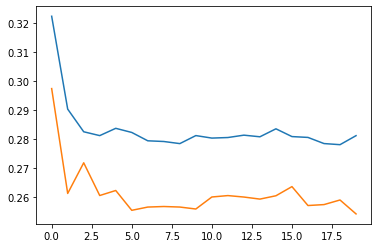

In [43]:
torch.save(model.state_dict(), 'model-efficientb0-lstm2.pth')
plt.plot(master_train_loss[:], label='train')
plt.plot(master_valid_loss[:], label='valid')

In [ ]:
with open('train_loss.pkl', 'wb') as f:
    pickle.dump(master_train_loss, f)
with open('valid_loss.pkl', 'wb') as f:
    pickle.dump(master_valid_loss, f)